<a href="https://colab.research.google.com/github/johnberg1/COMP447-547-S22/blob/main/homework1/HW1_Autoregressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Blackboard, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In the first problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check. In the second problem, you will train on one dataset (MNIST).

After each part, there will be a written question that you will need to answer about that part. These questions are given under the **Inline Question** title. You just need to write your answers below those questions.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want. Your graded submission will be the report you submit together with a copy of your notebook.

You will be implementing the code using PyTorch. Some parts of the code such as function headers are already provided to you, you will need to fill out the parts with "YOUR CODE HERE". Feel free to create more cells and more functions or modify the existing ones if you wish.

After you complete the assignment, download all of the image outputted in the results/ folder (which you can find on the left dashboard by clicking the folder icon) and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi 
!git clone https://github.com/johnberg1/deepul.git
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 206 (delta 85), reused 127 (delta 26), pack-reused 0
Receiving objects: 100% (206/206), 60.55 MiB | 25.91 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Processing ./deepul
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=19875 sha256=496f351af11cf1c59d52770c13053503dfa88ffe7c30a8c156b5bd9f6c2cf93b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jw0u2gc/wheels/40/86/14/ae5eebf191515af53ab86be6

In [2]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


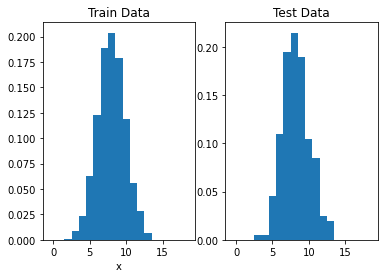

Dataset 2


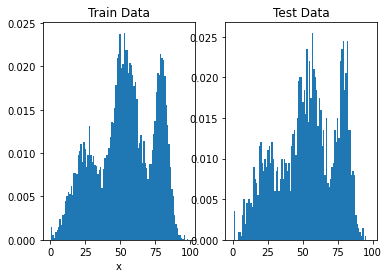

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram (5 Points)

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the functions below and return the necessary arguments. Feel free to create more cells if need be.

Implement the Histogram class which extends nn.Module, you will need to create the parameters of the model and provide a loss given a batch of data. In the get_distribution function, you will return a valid probability distribution which sums up to 1. You may want to take a look at the documentations of torch.nn.functional.cross_entropy() and torch.nn.functional.softmax()

After creating your model, you will train your model on the training set and evaluate on the test set. 

**Hint**: You may want to implement training and the evaluation procedures as functions which take a model and the dataloaders as an input and return the losses. This way, you can use these functions to train all the models you will create in this homework by simply calling them from inside the necessary functions such as 'q1_a' or 'q1_b'

In [4]:
import torch
import torch.optim as optim
        
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [5]:
# Auxilary functions defined below -->

def train_epoch(model, data_loader, optimizer):
    # iterate through the batches of data in the data_loader
    overall_loss = 0 # total loss
    for i, train_data in enumerate(data_loader):
        # calculate the training loss
        cur_loss = model.loss(train_data) # current loss for the given batch
        optimizer.zero_grad()
        # calculate the partial derivatives
        cur_loss.backward()
        # update the parameters
        optimizer.step()
        # update the training loss
        overall_loss = overall_loss + (cur_loss.item() * len(train_data)) # running sum of batch losses
        # Note that cur_loss.item() returns the mean batch loss
        
        
    # return the training_loss
    return overall_loss / len(data_loader.dataset) # return the averaged loss


def train(model, train_data_loader, test_data_loader, num_epochs, optimizer):# Fully initialized instance of an optimizer should be passed in
    model.train() # put the model in the training mode
    
    train_losses = [] # holds the training losses
    eval_losses = []
    
    # specifically calculate the eval/test loss before any training epoch
    initial_eval_loss = evaluate(model, test_data_loader)
    eval_losses.append(initial_eval_loss)
    
    # train for epochs
    for i in range(num_epochs): # train for num_epochs
        # perform training for one epoch
        current_train_loss = train_epoch(model, train_data_loader, optimizer)
        # append the training loss
        train_losses.append(current_train_loss)
        
        # Calculate the evaluation loss
        current_eval_loss = evaluate(model, test_data_loader)
        # append the evaluation loss
        eval_losses.append(current_eval_loss)
        
    return train_losses, eval_losses


def evaluate(model, data_loader):
    model.eval() # put the model in the evaluation mode
    # calculate the evaluation/test loss
    with torch.no_grad():
        overall_loss = 0 # averaged total loss
        for test_data in data_loader:
            cur_loss = model.loss(test_data)
            overall_loss = overall_loss + (cur_loss.item() * len(test_data)) # running sum of batch losses
            # Note that cur_loss.item() returns the mean batch loss
        #return the averaged loss
        return overall_loss / len(data_loader.dataset)
        
    

In [6]:
class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        """ YOUR CODE HERE """
        self.d = d
        self.theta = torch.nn.Parameter(torch.zeros(d), requires_grad=True) # initialize theta with zeros (d-dimensional)


    def loss(self, x):
        """ YOUR CODE HERE """
        # x consists of x.shape[0] many samples so in order to match that we need to convert self.theta to a similar shape
        # for batch processing of input and target theta values using the cross_entropy as loss function.
        num_samples = x.shape[0] # number of samples in the given batch
        theta_batch = self.theta.repeat(num_samples, 1) # repeat self.theta num_samples times in the dim=0
        # calculate the loss
        loss = torch.nn.functional.cross_entropy(theta_batch, x)
        return loss

    def get_distribution(self):
        """ YOUR CODE HERE """
        # use the given softmax definition of p(x) to compute the distribution
        # Note that 
        with torch.no_grad():
            dist = torch.nn.functional.softmax(self.theta)
            return dist.numpy()

In [7]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    """ YOUR CODE HERE """
    # Hyperparameters
    lr = 2e-1
    num_epochs = 20
    batch_size = 64

    # initialize the model
    model = Histogram(d)

    # initialize the optimizer to be used during training
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # prepare the DataLoaders from the given Datasets
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size) # Note that test set does not require shuffling

    # train the model 
    train_losses, eval_losses = train(model, train_data_loader, test_data_loader, num_epochs, optimizer)

    return train_losses, eval_losses, model.get_distribution()

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Test Loss: 2.1244


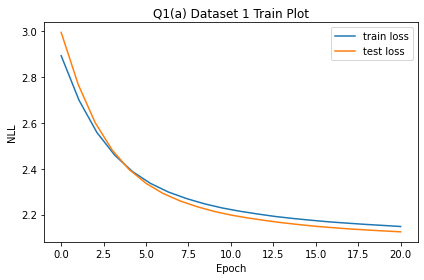

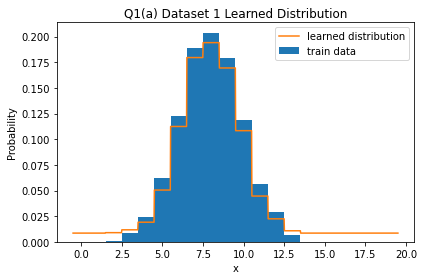

In [8]:
q1_save_results(1, 'a', q1_a)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Test Loss: 4.3701


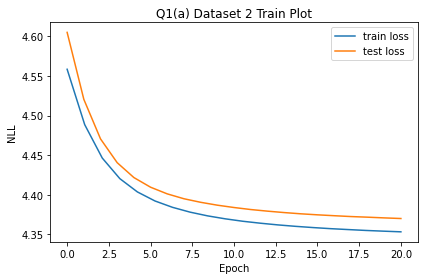

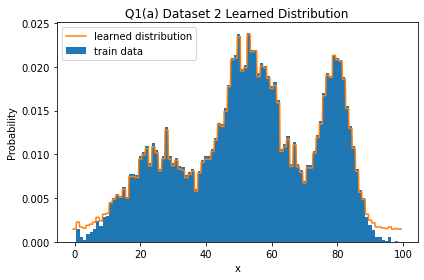

In [9]:
q1_save_results(2, 'a', q1_a)

 ### <font color='red'> Inline Question 1 </font>

*   What is the number of parameters of your Histogram model, for dataset 1 and dataset 2?
    

*   Supose that you are implementing a Histogram to model 28x28 binary images (each pixel has value of {0,1}). How many parameters would this model need to have? Is this a feasible way to model image distributions?
    
<font color="green"> My Answers</font>

<font color='green'> Ans1) </font>
         Number of parameters of the Histogram model equals the value of self.d since our model is a Histogram. For dataset 1, the number of parameters of the Histogram model is 20. For dataset 2, the number of parameters of the Histogram model is 100.


<font color='green'> Ans2) </font>
    It would need to have 28 * 28 * 2 = 1568 parameters. Thi is not a feasible way to model image distribution since using a histogram model won't generalize well and it won't be able to make sense of the spatial information present in the image.
    


## Part (b) Fitting Discretized Mixture of Logistics (5 Points)

Let us model $p_\theta(x)$ as a **discretized** mixture of 6 logistics such that $p_\theta(x) = \sum_{i=1}^6 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the functions below and return the necessary arguments. Feel free to create more cells if need be. 

Implement the MixtureOfLogistics class which extends nn.Module. Similar to the first part, you will create the parameters, implement the forward pass, loss functions and provide a function which returns a valid probability distribution.

Possible functions that might help: torch.sigmoid(), torch.clamp(), F.log_softmax()

In [10]:
class MixtureOfLogistics(nn.Module):
    def __init__(self, d, n_mix=6):
      super().__init__()
      """ YOUR CODE HERE """
      self.d = d
      self.n_mix = n_mix
      self.pi = torch.nn.Parameter(torch.zeros(self.n_mix), requires_grad = True)
      self.mean = torch.nn.Parameter(torch.arange(n_mix).float() / (n_mix - 1) * d, requires_grad = True) # NOT SURE !!!
      # we are using log_scale which we'll exponentiate later for stability reasons
      self.log_scale = torch.nn.Parameter(torch.randn(self.n_mix), requires_grad = True)

    def forward(self, x):
        """ YOUR CODE HERE """
        # Note that x is [batch_size x 1] dimensional, and every x can take a single value btw [0, (d-1)]
        x = x.float().unsqueeze(1).repeat(1, self.n_mix) # [batch_size x n_mix] 
        mean= self.mean.unsqueeze(0) # [1 x n_mix]
        log_scale =  self.log_scale.unsqueeze(0) # [1 x n_mix]

        inv_scales = torch.exp(-log_scale) # = 1/s

        # make use of vectorization below for (x - mean) --> [batch_size x n_mix]
        plus = inv_scales * ((x - mean) + 0.5) # = (x + 0.5 - mean) / s --> input to the sigmoid for rigth envelope (CDF value)
        min = inv_scales * ((x - mean) - 0.5) # = (x - 0.5 - mean) / s --> input to the sigmoid for left envelope (CDF value)
        # Note that sigmoid serves as a CDF (Cumulative Distribution Function)

        cdf_plus = torch.sigmoid(plus) # right of envelope, sigmoid(x+05) --> [batch_size x n_mix]
        cdf_min = torch.sigmoid(min) # # left of envelope, sigmoid(x-05) --> [batch_size x n_mix]

        cdf_delta = torch.clamp(cdf_plus - cdf_min, min=1e-15) # PDF value of X approximately derived from CDF. 
        # Note that we avoid Arithmetic Exceptions due to 0 by using torch.clamp
        log_cdf_delta = torch.log(cdf_delta)  # log likelihood


        # Handle the edge cases
        # For x = 0, we replace x - 0.5 by -inf. Therefore PDF value for x = 0 should equal to CDF value of x + 0.5
        pdf_zero = torch.log(torch.clamp(torch.sigmoid(inv_scales * ((0 + 0.5) - mean)),
                                                          min=1e-15)) 
        # For x = (d - 1) we replace x + 0.5 by +inf. Therefore PDF value for x = (d-1) should equal to (1 - CDF(x - 0.5))
        pdf_d = torch.log(torch.clamp(1 - torch.sigmoid(inv_scales * ((self.d - 1) -0.5 - mean)),
                                            min=1e-15)) # same logic applied to x = 0 before but this time done for x = d-1

        # Apply the edge case handling to our log likelihood (log_cdf_delta)
        x_log_probs = torch.where(x < 0.001, pdf_zero,
                                  torch.where(x > (self.d - 1) - 1e-3,
                                              pdf_d, log_cdf_delta))
        
        pi_log_probs = F.log_softmax(self.pi, dim=0).unsqueeze(0) # --> [1 x n_mix] with vectorization it'll become [batch_size, n_mix]
        # calculate: pi * (sigmoid(x+0.5) - sigmoid(x-0.5)) for all dim_n
        log_probs = x_log_probs + pi_log_probs # We sum due to properties of logarithm. Actually we're multiplying pi values with corresponding  PDF values
        return torch.logsumexp(log_probs, dim=1) 



    def loss(self, x):
        """ YOUR CODE HERE """
        # Negative Log Likelihood Loss
        loss = -1 * torch.mean(self.forward(x)) 
        # Note that self.forward returns negative log likelihoods so we just average to have the loss
        # because, we want the probability of every x to be as high as possible
        return loss

    def get_distribution(self):
        """ YOUR CODE HERE """
        with torch.no_grad():
          possible_x_values = torch.arange(self.d).float() # x values in range [0, d-1]
          logarithm_of_pdf_x_vals = self.forward(possible_x_values) # self.forward returns log likelihood values so we need to exponentiate to get PDF values
          pdf_x_vals = torch.exp(logarithm_of_pdf_x_vals)
          return pdf_x_vals.numpy()



In [11]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    """ YOUR CODE HERE """
    # Hyperparameters
    lr = 2e-1
    num_epochs = 50
    batch_size = 64

    # initialize the model
    model = MixtureOfLogistics(d, 6)
    # initialize the optimizer to be used during training
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # prepare the DataLoaders from the given Datasets
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size) # Note that test set does not require shuffling

    # train the model 
    train_losses, eval_losses = train(model, train_data_loader, test_data_loader, num_epochs, optimizer)

    return train_losses, eval_losses, model.get_distribution()

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.0638


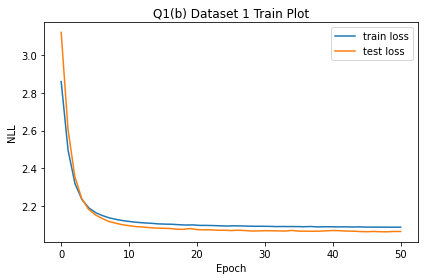

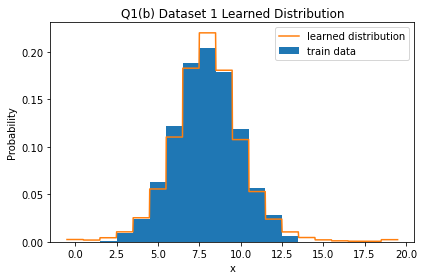

In [12]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 4.3642


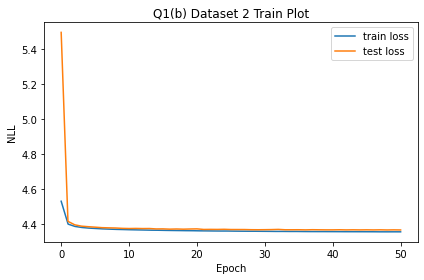

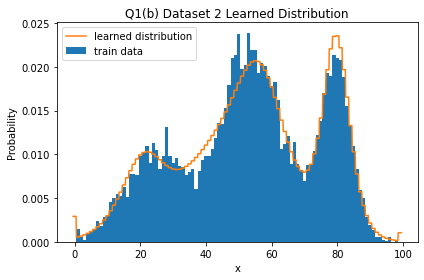

In [13]:
q1_save_results(2, 'b', q1_b)

 ### <font color='red'> Inline Question 2 </font>

*   Please run the experiments **on dataset 2** with `n_mix = 2` and `n_mix = 4` again and observe the changes in the results. Are your results as good as the results with `n_mix = 6`? Why do you think this happens? Please explain briefly. (Note that for the report, **you need to include the results for** `n_mix = 6` **only**, the other experiments are just for you to observe).

<font color='green'> My Answers </font>
* No, with `n_mix = {2,4}` the results are not as good as the results with `n_mix = 6`. I think this happens because, as the `n_mix` value decreases the expressive capability (its ability to model complex distributions) decreases too. For example, in the extreme case of `n_mix = 1` the Mixture of Logistics model reduces to a single sigmoid function. With increasing `n_mix > 1`, we are able to train model to learn multiple distributions which can be switched on/off to yield results from a corresponding distribution which ideally expresses the given input better.

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN model and its variations on MNIST. In the first part, you will implement a PixelCNN that is trained with the default Cross Entropy Loss. In the second part, you will implement the alternative loss proposed in PixelCNN++, mixture of logistics. In the final part, you will implement the gated version, GatedPixelCNN.

## Part (a) PixelCNN on MNIST (10 Points)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
import sys
from torch import optim
from torch.utils import data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You will train your model on MNIST. Let's download the dataset and visualize an example:

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/data
    Split: Train
    StandardTransform
Transform: ToTensor()


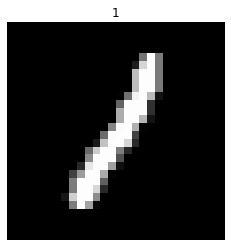

In [15]:
dataset_path = '/content/data'
transform = transforms.ToTensor()
train_data = datasets.MNIST(root=dataset_path,
                            train=True,
                            download=True,
                            transform=transform)
test_data = datasets.MNIST(root=dataset_path,
                            train=False,
                            download=True,
                            transform=transform)
print(train_data)

plt.imshow(train_data.data[447], cmap='gray')
plt.title('%i' % train_data.targets[447])
plt.axis('off')
plt.show()

In [16]:
# Examine the shape of the training data
print("train_data.data.shape = ", str(train_data.data.shape))
print("train_data.data.max() = ", train_data.data.max())

train_data.data.shape =  torch.Size([60000, 28, 28])
train_data.data.max() =  tensor(255, dtype=torch.uint8)


### Solution

In this part, you will implement a very simple PixelCNN architecture on greyscale handwritten digits. This model will be trained with the default Cross Entropy Loss.

As you have seen in the lecture, PixelCNN utilizes masked convolutions to ensure the autoregressive property is satisfied. First start by implementing a masked convolutional layer. Remember that there are two different types of layers, type A and type B, depending on the masking you are using.

A class header is provided to you in the cell below, which extends the `nn.Conv2d` class. You may wish to implement your layer that extends the `nn.Module` class instead.

In [17]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        """ YOUR CODE HERE """
        super().__init__(*args, **kwargs) # pass additional arguments directly to the Conv2d's constructor
        assert mask_type in {'A', 'B'}

        # Conv2d accepts kernel_size as tuple or a single int so be sure to handle it for our mask too
        if type(self.kernel_size) == tuple:
            kernel_size = self.kernel_size[0]

        mask = torch.zeros((self.out_channels, self.in_channels, kernel_size, kernel_size)) # initialize the mask with zeros
        center = (kernel_size // 2) # index of the center's left weight of the kernel
        if mask_type == 'A':
            mask[:, :, :center, :] = 1
            mask[:, :, center, :center] = 1
        else:
            mask[:, :, :center, :] = 1
            mask[:, :, center, :(center + 1)] = 1 # center pixel should also be 1 for 'type B'

        # Note that mask is defined using register_buffer, and not nn.Parameter because it won't be updated during training
        self.register_buffer('mask', mask)


    def forward(self, x):
        """ YOUR CODE HERE """
        pred = F.conv2d(input=x, weight=self.weight * self.mask, bias=self.bias, stride=self.stride, padding=self.padding)
        return pred

In [18]:
# Check out mask and Conv2d filter sizes
test = MaskedConv2d('A', in_channels=1, out_channels=2, kernel_size=3)
print(test.weight.shape)
print(test.mask.shape)
print(test.bias.shape)
print(test.mask)

torch.Size([2, 1, 3, 3])
torch.Size([2, 1, 3, 3])
torch.Size([2])
tensor([[[[1., 1., 1.],
          [1., 0., 0.],
          [0., 0., 0.]]],


        [[[1., 1., 1.],
          [1., 0., 0.],
          [0., 0., 0.]]]])


Now that you have implemented a masked convolutional layer, you can use this layer inside your PixelCNN model. Again, a class header is provided to you. Here is a pseudocode for the reference implementation:



```
class PixelCNN:
  MaskedConv(mask_type='A', in_channels = 1, out_channels = 64, kernel_size = 7, stride = 1, padding = 3)
  BatchNorm(num_features=64)
  ReLU()

  for _ in range(3):
    MaskedConv(mask_type='B', in_channels = 64, out_channels = 64, kernel_size = 7, stride = 1, padding = 3)
    BatchNorm(num_features=64)
    ReLU()

  MaskedConv(mask_type='B', in_channels = 64, out_channels = 64, kernel_size = 1)
  BatchNorm(num_features=64)
  ReLU()
  MaskedConv(mask_type='B', in_channels = 64, out_channels = 256, kernel_size = 1)

```



In [19]:
class PixelCNN(nn.Module):
    def __init__(self, num_layers = 5, num_channels = 64, kernel_size = 7):
        """ YOUR CODE HERE """
        super().__init__()
        self.layers = []
        self.layers.extend([MaskedConv2d(mask_type='A', in_channels=1, out_channels=num_channels, kernel_size=kernel_size, 
                    stride=1, padding=3),
                            torch.nn.BatchNorm2d(num_features=64),
                            torch.nn.ReLU()])

        for _ in range(num_layers):
            self.layers.extend([MaskedConv2d(mask_type='B', in_channels=num_channels, out_channels=num_channels, kernel_size=kernel_size, 
                    stride=1, padding=3),
                            torch.nn.BatchNorm2d(num_features=64),
                            torch.nn.ReLU()])
        
        self.layers.extend([MaskedConv2d(mask_type='B', in_channels=num_channels, out_channels=num_channels, kernel_size=1),
                            torch.nn.BatchNorm2d(num_features=64),
                            torch.nn.ReLU(),
                           MaskedConv2d(mask_type='B', in_channels=num_channels, out_channels=256, kernel_size=1)])
        
        self.model = torch.nn.Sequential(*self.layers)


    def forward(self, x):
        """ YOUR CODE HERE """
        pred = self.model(x)
        return pred

    def loss(self, test_data):
        """ YOUR CODE HERE """
        # calculate the loss
        pred = self.model(test_data)   # --> [batch_size, 256, H, W]
        loss = torch.nn.functional.cross_entropy(pred, (test_data[:,0,:,:]*255).long())
        return loss
        

Now you are ready to train your model. Fill in the function `q2_a` below to train the model and return the correct deliverables. In this function, you will initialize your model and train this model. The reference implementation uses `batch_size = 128`, `num_epocs = 5`, `optimizer = Adam`, `lr = 1e-3` as hyperparameters. Use Cross Entropy Loss to train this model, please look at the documentation of this loss. It should take around 16 minutes to train for 5 epochs

**You will provide the following deliverables:**

*   **A list of training losses evaluated at every minibatch. (Create an empty list before training, append the loss after every minibatch and return the final list).**
*   **A list of test losses evaluated once at initialization and after each epoch. (Create an empty list. Evaluate on the test set before training and append it to this list. After every epoch, evaluate on the test set again and append to the list. Return the final list).**
*   **25 samples drawn from your trained model. (The sampling function is already provided to you. Just call this function after training and return the samples).**

Here is a pseudocode for the reference implementation. Once again, you may wish to implement a generic training function (`train_model`) that takes your model and dataloaders and returns the training losses:


```
function q2a():
  batch_size = 128
  num_epochs = 5
  train_loader = data.DataLoader(train_data, ...)
  test_loader = data.DataLoader(test_data, ...)
  device = 'cuda:0' or 'cpu'
  model = PixelCNN().to(device)
  train_losses, test_losses = train_model(model, train_loader, test_loader, ...)
  
  samples = sample(model)
  return train_losses, test_losses, samples

```



In [20]:
def train(model, train_data_loader, test_data_loader, num_epochs, optimizer):
    train_losses = []
    val_losses = []
    # initial test_loss
    test_losses = evaluate(model, test_data_loader)
    val_losses.append(test_losses)
    
    # training/test losses
    for i in range(num_epochs):
        cur_train_loss, cur_val_loss = train_one_epoch(model, train_data_loader, test_data_loader, optimizer)
        train_losses.extend(cur_train_loss)
        val_losses.append(cur_val_loss)
        print("Epoch: ", i, ",\t training_loss: ", np.mean(cur_train_loss, axis=-1), ",\t validation loss:", cur_val_loss)
    return train_losses, val_losses


def train_one_epoch(model, train_data_loader, test_data_loader, optimizer):
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
            
    
    model.train()
    train_losses = []
    for x, y in train_data_loader:
        x = x.to(device)
        y = y.to(device)
        
        # train
        cur_loss = model.loss(x)
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        
        train_losses.append(cur_loss.item())
        
    # test
    test_losses = evaluate(model, test_data_loader)
    
    return train_losses, test_losses

def evaluate(model, test_data_loader):
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
  
    test_losses = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_data_loader:
            x = x.to(device)
            y = y.to(device)
            
            cur_loss = model.loss(x)
            test_losses += (cur_loss.item() * len(x))
        test_losses /= len(test_data_loader.dataset)
        return test_losses

In [21]:
# Execute this cell, nothing to implement here
def sample(model):
    """
    model: PixelCNN model trained on MNIST

    Returns
    - sample: A tensor containing the samples generated by the model
    """

    no_images = 25
    images_channels = 1
    images_size = 28
    sample = torch.Tensor(no_images, images_channels, images_size, images_size).cuda()
    sample.fill_(0)

    for i in range(images_size):
        for j in range(images_size):
            out = model(sample)
            probs = F.softmax(out[:,:,i,j], dim=-1).data
            sample[:,:,i,j] = torch.multinomial(probs, 1).float() / 255.0
    return sample.cpu()

In [22]:
def q2_a(train_data, test_data):
    """
    train_data: A (n_train, H, W) numpy array of greyscale MNIST images
    test_data: A (n_test, H, W) numpy array of greyscale MNIST images

    Returns
    - a (# of training iterations,) list of train_losses evaluated every minibatch
    - a (# of epochs + 1,) list of test_losses evaluated once at initialization and after each epoch
    - a tensor containing samples generated by the trained model
    """

    """ YOUR CODE HERE """
    # hyperparameters
    batch_size = 128
    num_epochs = 5
    lr = 1e-3
    
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)
        
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
                                  
    model = PixelCNN()
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)    

    train_losses, test_losses = train(model, train_loader, test_loader, num_epochs= num_epochs, optimizer=optimizer)

    samples = sample(model)
    
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cell below to visualize and save your results

In [23]:
train_data.data.unsqueeze(1).shape
np.expand_dims(train_data.data, 1).shape
train_data.data.shape
test_data.data.shape
torch.max(test_data.data[:])

tensor(255, dtype=torch.uint8)

Epoch:  0 ,	 training_loss:  1.2200620264641002 ,	 validation loss: 0.807062302684784
Epoch:  1 ,	 training_loss:  0.7866608107776276 ,	 validation loss: 0.7664076286315918
Epoch:  2 ,	 training_loss:  0.7595943559461565 ,	 validation loss: 0.7509861299514771
Epoch:  3 ,	 training_loss:  0.7472954722864034 ,	 validation loss: 0.7425000492095948
Epoch:  4 ,	 training_loss:  0.7392718131099937 ,	 validation loss: 0.7319034459114074
Final Test Loss: 0.7319


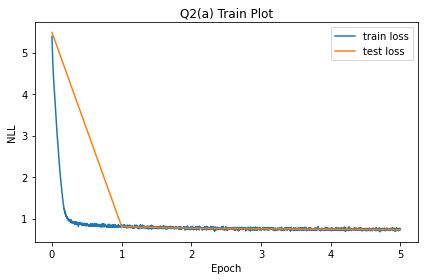

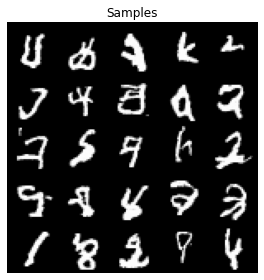

In [24]:
q2a_save_results(q2_a, train_data, test_data)

 ### <font color='red'> Inline Question 3 </font>

*   Bits per dim is a common metric to evaluate these autoregressive models such as PixelCNN. Please describe what bits per dim is, what is its relationship with log-likelihood and how it is calculated.

<font color='green'> My Answers </font>
* Bits per dim is an evaluation metric that is widely used in Generative model related papers for performance comparison between models. It solves the problem of being able to compare performance of the models on different datasets. For example, one dataset can be comprised of images of size 8x8 whereas another dataset might have images of size 32x32. To calculate bits per dim, compute the negative log likelihood in base e. Then apply change of base for converting log base e to log base 2. Finally divide by the number of pixels (dim) (e.g. 2352 pixels for a 28x28 rgb image). To change base for the log, just divide the log base e value by log(2). Its relationship to log-likelihood is aparrent from the aforementioned equation which shows how one can be derived given the other.


## Part (b) PixelCNN+ on MNIST (15 Points)

In this part, you will implement the mixture of logistics used in PixelCNN++, instead of the cross entropy loss used in the original PixelCNN. We call this model PixelCNN+, since we are only adapting the loss function and not implementing the other details presented in PixelCNN++. Let's start by loading the dataset, this time we will normalize the pixels to be in the range [-1,1]

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               <function <lambda> at 0x7fbe59b58b00>
           )


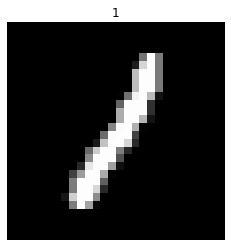

In [25]:
dataset_path = '/content/data'
rescaling     = lambda x : (x - .5) * 2.
rescaling_inv = lambda x : .5 * x  + .5
transform = transforms.Compose([transforms.ToTensor(), rescaling])
train_data = datasets.MNIST(root=dataset_path,
                            train=True,
                            download=True,
                            transform=transform)
test_data = datasets.MNIST(root=dataset_path,
                            train=False,
                            download=True,
                            transform=transform)
print(train_data)

plt.imshow(train_data.data[447], cmap='gray')
plt.title('%i' % train_data.targets[447])
plt.axis('off')
plt.show()

In [26]:
# Take a look at the data
print("train_data.data.shape=", train_data.data.shape)
print("train_data.data[0].shape=", train_data.data[0].shape)
print("torch.min(train_data.data)=", torch.min(train_data.data))
print("torch.max(train_data.data)=", torch.max(train_data.data))

train_data.data.shape= torch.Size([60000, 28, 28])
train_data.data[0].shape= torch.Size([28, 28])
torch.min(train_data.data)= tensor(0, dtype=torch.uint8)
torch.max(train_data.data)= tensor(255, dtype=torch.uint8)


### Solution

Please complete the `PixelCNNPlus` class below. Your model will be almost exactly the same with part (a), with a small modification on the last convolutional layer. Since we will output a mixture of logistics, instead of a 256 way softmax, the number of output channels should be equal to `3 * number_of_mixtures`. In the reference implementation, we use the `number_of_mixtures = 10`, therefore the last convolutional layer has `30` filters in total.

In [27]:
class PixelCNNPlus(nn.Module):
  def __init__(self, num_layers = 5, num_channels = 64, kernel_size = 7):
    """ YOUR CODE HERE """
    super().__init__()
    self.layers = []
    self.layers.extend([MaskedConv2d(mask_type='A', in_channels=1, out_channels=num_channels, kernel_size=kernel_size, 
                stride=1, padding=3),
                        torch.nn.BatchNorm2d(num_features=64),
                        torch.nn.ReLU()])

    for _ in range(num_layers):
        self.layers.extend([MaskedConv2d(mask_type='B', in_channels=num_channels, out_channels=num_channels, kernel_size=kernel_size, 
                stride=1, padding=3),
                        torch.nn.BatchNorm2d(num_features=64),
                        torch.nn.ReLU()])
    
    self.layers.extend([MaskedConv2d(mask_type='B', in_channels=num_channels, out_channels=num_channels, kernel_size=1),
                        torch.nn.BatchNorm2d(num_features=64),
                        torch.nn.ReLU(),
                        MaskedConv2d(mask_type='B', in_channels=num_channels, out_channels=(3*10), kernel_size=1)])
    # Note that out_channels=(3*10) = (3*n_mix) --> 3 = (pi, mean, scale)
    
    self.model = torch.nn.Sequential(*self.layers)


  def forward(self, x):
    """ YOUR CODE HERE """
    pred = self.model(x)
    return pred

In [28]:
# Auxilary methods
def train(model, train_data_loader, test_data_loader, num_epochs, optimizer, loss):
    train_losses = []
    val_losses = []
    # initial test_loss
    test_losses = evaluate(model, test_data_loader, loss)
    val_losses.append(test_losses)
    
    # training/test losses
    for i in range(num_epochs):
        cur_train_loss, cur_val_loss = train_one_epoch(model, train_data_loader, test_data_loader, optimizer, loss)
        train_losses.extend(cur_train_loss)
        val_losses.append(cur_val_loss)
        print("Epoch: ", i, ",\t training_loss: ", np.mean(cur_train_loss, axis=-1), ",\t validation loss:", cur_val_loss)
    return train_losses, val_losses


def train_one_epoch(model, train_data_loader, test_data_loader, optimizer, loss):
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
            
    
    model.train()
    train_losses = []
    for x, y in train_data_loader:
        x = x.to(device)
        y = y.to(device)
        
        # train
        #cur_loss = model.loss(x)
        pred = model(x)
        cur_loss = loss(pred, x)
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        
        train_losses.append(cur_loss.item())
        
    # test
    test_losses = evaluate(model, test_data_loader, loss)
    
    return train_losses, test_losses

def evaluate(model, test_data_loader, loss):
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
  
    test_losses = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_data_loader:
            x = x.to(device)
            y = y.to(device)
            
            #cur_loss = model.loss(x)
            pred = model(x)
            cur_loss = loss(pred, x)
            test_losses += (cur_loss.item() * len(x))
        test_losses /= len(test_data_loader.dataset)
        return test_losses


The main implementation will be about the loss function. You need to implement **Discretized Logistic Mixture Likelihood** from PixelCNN++. Please take a look at the paper for the detailed explanation of this. Your implementation will be very similar to the Discretized Mixture of Logistics you implemented in Question 1 (b). However, here we will be working on images instead of 1-dimensional data. 

One important detail is that in this part, we normalize the data to be in the range [-1,1] when loading it, so the following function assumes that your data is in this range. Please fill out the following function:


In [29]:
def mix_of_logistics_loss(fake, real):
  """ YOUR CODE HERE """
  # Overview of the inputs:
  # fake is the output of model(x).
  # fake.shape = [batch_size, (3*n_mix), 28, 28] , it contains means, log_scales, pi s(logits)
  # real.shape = [batch_size, 28, 28]
  
  pred = fake
  # to generate meaningful samples convert [-1,1] range of the target pixels to [0,255] range
  real = ((real + 1) * (255/2)).long() 

  # Note that NN predicts pi,means,scales, and we want the model with those params 
  # to output high probability for the real values.
  for i in range(pred.shape[-1]):
    for j in range(pred.shape[-1]):
      # Extract mixture of logistics model parameters
      # Assume the parameters are predicted in the order given below, it totally depends on your implementation
      pi = pred[:,:10, i, j] # --> [batch_size, n_mix=10]
      mean = pred[:, 10:20, i, j] # --> [batch_size, n_mix=10]
      log_scale = pred[:, 20:, i, j] # --> [batch_size, n_mix=10]
      inv_scale = torch.exp(-log_scale) # = exp(log(1/s)) = s # This is done for the purpose of stability


      cur_pixels = real[:, 0, i, j].unsqueeze(1).repeat(1, 10) # --> [batch_size, n_mix]
      plus = (cur_pixels + 0.5 - mean) * inv_scale # --> [batch_size, n_dims]
      min = (cur_pixels - 0.5 - mean) * inv_scale # --> [batch_size, n_dims]

      # Calculate CDF and PDF values
      cdf_plus = torch.sigmoid(plus) # --> [batch_size, n_mix]
      cdf_min = torch.sigmoid(min) # --> [batch_size, n_mix]

      cdf_delta = torch.clamp(cdf_plus - cdf_min, min=1e-15) # PDF value of cur_pixels --> [batch_size, n_mix]
      log_cdf_delta = torch.log(cdf_delta) # log likelihood


      # Handle the edge cases
      # For x = 0, we replace x - 0.5 by -inf. Therefore PDF value for x = -1 should equal to CDF value of x + 0.5
      #pdf_zero = torch.log(torch.clamp(torch.sigmoid(inv_scale * ((-1 + 0.5) - mean)),
      #min=1e-15)) 
      pdf_zero = torch.log(torch.clamp(torch.sigmoid(inv_scale * ((0 + 0.5) - mean)),
      min=1e-15))
      # For x = 255 we replace x + 0.5 by +inf. Therefore PDF value for x = 1 should equal to (1 - CDF(x - 0.5))
      #pdf_d = torch.log(torch.clamp(1 - torch.sigmoid(inv_scale * ((1 - 0.5) - mean)),
      #min=1e-15)) # same logic applied to x = 0 before but this time done for x = d-1
      pdf_d = torch.log(torch.clamp(1 - torch.sigmoid(inv_scale * ((255 - 0.5) - mean)),
      min=1e-15))

      # Apply the edge case handling to our log likelihood (log_cdf_delta)
      #x_log_probs = torch.where(cur_pixels < -0.99, pdf_zero,
      #torch.where(cur_pixels > 1 - 1e-3,
      #pdf_d, log_cdf_delta))
      x_log_probs = torch.where(cur_pixels < 0.001, pdf_zero,
      torch.where(cur_pixels > 255 - 1e-3,
      pdf_d, log_cdf_delta))

      pi_log_probs = F.log_softmax(pi, dim=1) # --> [batch_size x n_mix]
      # calculate: pi * (sigmoid(x+0.5) - sigmoid(x-0.5)) for all n_mix
      log_probs = x_log_probs + pi_log_probs # We sum due to properties of logarithm. Actually we're multiplying pi values with corresponding PDF values
      return -1 * torch.mean(torch.logsumexp(log_probs, dim=1)) # return average loss for the given batch



Now, you need to use this loss as the loss function in your training loop, instead of the Cross Entropy Loss from part (a). You can borrow your previous training loops / functions, but you may need to do some small changes for compatibility of the losses etc.

Fill in the function `q2_b` below to train the model and return the correct deliverables. In this function, you will initialize your model and train this model. The reference implementation uses `batch_size = 128`, `num_epocs = 5`, `optimizer = Adam`, `lr = 1e-3` as hyperparameters. It should take around 16 minutes to train for 5 epochs

**You will provide the following deliverables:**

*   **A list of training losses evaluated at every minibatch. (Create an empty list before training, append the loss after every minibatch and return the final list).**
*   **A list of test losses evaluated once at initialization and after each epoch. (Create an empty list. Evaluate on the test set before training and append it to this list. After every epoch, evaluate on the test set again and append to the list. Return the final list).**
*   **25 samples drawn from your trained model. (The sampling function is already provided to you. Just call this function after training and return the samples).**

Here is a pseudocode for the reference implementation:


```
function q2b():
  batch_size = 128
  num_epochs = 5
  train_loader = data.DataLoader(train_data, ...)
  test_loader = data.DataLoader(test_data, ...)
  device = 'cuda:0' or 'cpu'
  model = PixelCNNPlus().to(device)
  train_losses, test_losses = train_model(model, train_loader, test_loader, ...)
  
  samples = sample_mixture(model)
  return train_losses, test_losses, samples

```

In [30]:
# Execute this cell, nothing to implement here
def sample_mix(model):
  """
  model: PixelCNNPlus model trained on MNIST

  Returns
  - sample: A tensor containing the samples generated by the model
  """
  obs = (1, 28, 28)
  sample_batch_size = 25
  sample_op = sample_from_discretized_mix_logistic_1d
  model.eval()
  samples = torch.zeros(sample_batch_size, obs[0], obs[1], obs[2])
  samples = samples.cuda()
  for i in range(obs[1]):
      for j in range(obs[2]):
          samples_v = samples
          out   = model(samples_v)
          out_sample = sample_op(out, nr_mix=10)
          samples[:, :, i, j] = out_sample.data[:, :, i, j]
  return rescaling_inv(samples).cpu()

In [31]:
def q2_b(train_data, test_data):
  """
  train_data: A (n_train, H, W) numpy array of greyscale MNIST images
  test_data: A (n_test, H, W) numpy array of greyscale MNIST images

  Returns
  - a (# of training iterations,) list of train_losses evaluated every minibatch
  - a (# of epochs + 1,) list of test_losses evaluated once at initialization and after each epoch
  - a tensor containing samples generated by the trained model
  """
  
  """ YOUR CODE HERE """
  # hyperparameters
  batch_size = 128
  num_epochs = 5
  lr = 1e-3

  train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=batch_size)
      
  if torch.cuda.is_available():
      device = 'cuda'
  else:
      device = 'cpu'
                                
  model = PixelCNNPlus()
  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss = mix_of_logistics_loss

  train_losses, test_losses = train(model, train_loader, test_loader, num_epochs= num_epochs, optimizer=optimizer, loss=loss)

  samples = sample_mix(model)

  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cell below to visualize and save your results

Epoch:  0 ,	 training_loss:  0.0038830580707115213 ,	 validation loss: 1.5779584646224974e-07
Epoch:  1 ,	 training_loss:  6.41340033683861e-08 ,	 validation loss: -5.736351013183594e-08
Epoch:  2 ,	 training_loss:  2.241048726360267e-08 ,	 validation loss: 6.534457206726075e-08
Epoch:  3 ,	 training_loss:  1.3254054002153116e-08 ,	 validation loss: -2.873241901397705e-08
Epoch:  4 ,	 training_loss:  1.0943784912639081e-08 ,	 validation loss: -1.5020370483398438e-09
Final Test Loss: -0.0000


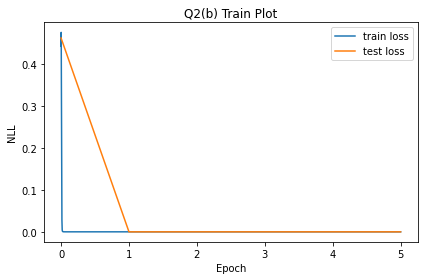

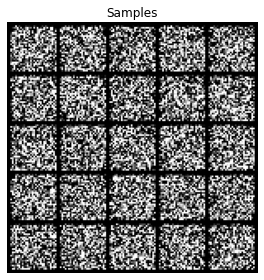

In [32]:
q2b_save_results(q2_b, train_data, test_data)

 ### <font color='red'> Inline Question 4 </font>

*   PixelCNN++ uses descretized mixture of logistics instead of negative log likelihood. Please explain briefly what mixture of logistics is and why is it preferred when modeling distribution of images.

<font color='green'> My Answers </font>
* Mixture of logistics is a type of output function, and an alternative to a softmax layer. It is useful for modeling complex distributions. It is preferred when modeling distribution of images since, images are usually complex and their aspects usually are more complex to be modelled by using a single simple distribution. Mixture of logistics solves this issue by allowing one to learn a weighted combination of multiple simple distributions, in which the number of distributions is a hyperparameter, to model better.

## Part (c) GatedPixelCNN on MNIST (15 Points)

We will again train on MNIST. This time, we do not need to normalize the data.

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/data
    Split: Train
    StandardTransform
Transform: ToTensor()


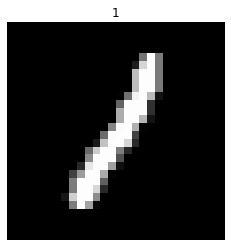

In [33]:
dataset_path = '/content/data'
transform = transforms.ToTensor()
train_data = datasets.MNIST(root=dataset_path,
                            train=True,
                            download=True,
                            transform=transform)
test_data = datasets.MNIST(root=dataset_path,
                            train=False,
                            download=True,
                            transform=transform)
print(train_data)

plt.imshow(train_data.data[447], cmap='gray')
plt.title('%i' % train_data.targets[447])
plt.axis('off')
plt.show()

In [34]:
print(train_data.data.shape)

torch.Size([60000, 28, 28])


### Solution

In this part, you will implement the gated version of the PixelCNN, which solves the blind spot problem of PixelCNN. Please take a look at [the paper](https://arxiv.org/pdf/1606.05328.pdf) for the detailed implementation.

First, we will start by implementing a GatedConv2d layer, following Figure 2 of the paper: ![gated](https://drive.google.com/uc?export=view&id=1slOjRQeQaQSVDUCPj6ZsUPFXDQsD9kua)

Please take a look at this figure and read the Gated Convolutional Layers part of the paper carefully to implement the following function. This layer should include 4 convolutions with different kernel sizes, as shown in the figure. Again, a header is provided to you, but you may wish to write your own class or your own functions:



In [35]:
class GatedConv2d(nn.Module):
  def __init__(self, mask_type, in_channels, out_channels, kernel_size=7, padding=3):
    """ YOUR CODE HERE """
    super().__init__()
    assert mask_type in {'A', 'B'}
    k = kernel_size
    # Vertical Convolution Filter (nxn)
    self.vertical = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=k,
                              padding=padding, bias=False)
    # Horizontal Convolution Filter (1xn)
    self.horizontal = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=(1, k),
                                padding=(0, padding), bias=False) # No need to pad height since kernel has H = 1
    
    # 1x1 convolution Filters below
    self.vtoh = nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=1, 
                            bias=False)
    self.htoh = nn.Conv2d(out_channels, out_channels, kernel_size=1, 
                            bias=False)


    # Create masks (vmask & hmask) separately for masking vertical Conv2d and horizontal Conv2d weights
    # to comply with the autoregressive property of architecture.
    # Note that these masks are registered as buffers since they won't be trained with optimization
    self.register_buffer('vmask', self.vertical.weight.data.clone()) # Create a tensor with the same shape as the vertical Conv2d Weight
    self.register_buffer('hmask', self.horizontal.weight.data.clone()) # Create a tensor with the same shape as the Horizontal Conv2d Weight

    # We fill the masks with 1's which we will replace some with 0's to mask the future input elements
    self.vmask.fill_(1)
    self.hmask.fill_(1)
    # zero the mask's lower half coordinates for the Vertical Mask for autoregressive purposes
    self.vmask[:, :, k // 2 + 1:, :] = 0 # --> [batch_size, C, H, W] 
    # zero the mask's right half coordinates for the Horizontal Mask for autoregressive purposes
    self.hmask[:, :, :, k // 2 + 1:] = 0
    if mask_type == 'A':
      self.hmask[:, :, :, k // 2] = 0

  def down_shift(self, x):
      x = x[:, :, :-1, :] # --> [batch_size, C, H, W]
      pad = nn.ZeroPad2d((0, 0, 1, 0))
      return pad(x)


  def forward(self, x):
    """ YOUR CODE HERE """
    # Since we receive x --> [B, 2* original_in_channel, H, W] by doing 
    # this chunk operation we obtain two identical copies of the original input (vx = hx)
    vx, hx = x.chunk(2, dim=1) # Assume x has 2p channels then, vx and vh have p channels

    self.vertical.weight.data *= self.vmask # Apply masking to Vertical Conv2d weights
    self.horizontal.weight.data *= self.hmask # Apply masking to Horizontal Conv2d weights

    vx = self.vertical(vx) # Forward pass with Vertical Filter
    hx_new = self.horizontal(hx) # Forward pass with Horizontal filter
    # Allow horizontal stack to see information from vertical stack
    hx_new = hx_new + self.vtoh(self.down_shift(vx)) # add 1x1 Filter Convolved Vertical Convolution output to Horizontal Convolution output  

    # Gates
    vx_1, vx_2 = vx.chunk(2, dim=1) # divide 2p channeled vx to two p channel partitions
    vx = torch.tanh(vx_1) * torch.sigmoid(vx_2) # LSTM alike gate

    hx_1, hx_2 = hx_new.chunk(2, dim=1)
    hx_new = torch.tanh(hx_1) * torch.sigmoid(hx_2)
    hx_new = self.htoh(hx_new)
    hx = hx + hx_new # residual connection alike addition for the Horizontal Conv2d input
    return torch.cat((vx, hx), dim=1) # return 2p channelled

Now, you can use this layer inside your GatedPixelCNN++ model. Here is a pseudocode for the reference implementation:



```
class GatedPixelCNN
  MaskedConv2d(mask_type='A', in_channels = 1, out_channels = 120, kernel_size = 7, padding = 3)
  BatchNorm(num_features=2*120)
  ReLU()

  for _ in range(3):
    GatedConv2d(mask_type='B', in_channels = 120, out_channels = 120, kernel_size = 7, padding = 3)
    BatchNorm(num_features=2*120)
    ReLU()
  
  MaskedConv2d(mask_type='B', in_channels = 120, out_channels = 256, kernel_size = 7, padding = 3)


```



In [36]:
class GatedPixelCNN(nn.Module):
  def __init__(self, num_layers = 5, num_channels = 120, kernel_size=7):
    """ YOUR CODE HERE """
    super().__init__()
    
    # 1^st NN
    self.in_conv = torch.nn.Sequential(
                   MaskedConv2d(mask_type='A', in_channels=1, out_channels=120, kernel_size=7, padding=3),
                   )
    
    # 2^nd NN
    self.layers = []
    self.layers.extend([torch.nn.BatchNorm2d(num_features=2*120),
                   torch.nn.ReLU()])
    for _ in range(3):
      self.layers.extend([
                          GatedConv2d(mask_type='B', in_channels=120, out_channels=120, kernel_size=7, padding=3),
                          torch.nn.BatchNorm2d(num_features=2*120),
                          torch.nn.ReLU()
      ])
    self.net = torch.nn.Sequential(*self.layers)

    # 3^rd NN
    self.out_conv = torch.nn.Sequential(MaskedConv2d(mask_type='B', in_channels=120, out_channels=256, kernel_size=7, padding=3))
      
  def forward(self, x):
    """ YOUR CODE HERE """
    batch_size = x.shape[0]

    out = self.in_conv(x) # Regular Masked Convolution Forward pass
    out = self.net(torch.cat((out, out), dim=1)).chunk(2, dim=1)[1] # Series of Gated Convolution Forward pass
    out = self.out_conv(out) # Regular Masked Convolution Forward pass
    
    return out
    

In [37]:
# Auxilary methods
def train(model, train_data_loader, test_data_loader, num_epochs, optimizer, loss):
    train_losses = []
    val_losses = []
    # initial test_loss
    test_losses = evaluate(model, test_data_loader, loss)
    val_losses.append(test_losses)
    
    # training/test losses
    for i in range(num_epochs):
        cur_train_loss, cur_val_loss = train_one_epoch(model, train_data_loader, test_data_loader, optimizer, loss)
        train_losses.extend(cur_train_loss)
        val_losses.append(cur_val_loss)
        print("Epoch: ", i, ",\t training_loss: ", np.mean(cur_train_loss, axis=-1), ",\t validation loss:", cur_val_loss)
    return train_losses, val_losses


def train_one_epoch(model, train_data_loader, test_data_loader, optimizer, loss):
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
            
    
    model.train()
    train_losses = []
    for x, y in train_data_loader:
        x = x.to(device)
        y = y.to(device)
        
        # train
        pred = model(x)
        cur_loss = loss(pred, (x[:,0,:,:]*255).long())
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        
        train_losses.append(cur_loss.item())
        
    # test
    test_losses = evaluate(model, test_data_loader, loss)
    
    return train_losses, test_losses

def evaluate(model, test_data_loader, loss):
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
  
    test_losses = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_data_loader:
            x = x.to(device)
            y = y.to(device)
            
            pred = model(x)
            cur_loss = loss(pred, (x[:,0,:,:]*255).long())
            test_losses += (cur_loss.item() * len(x))
        test_losses /= len(test_data_loader.dataset)
        return test_losses

Now you are ready to train your model. Fill in the function `q2_c` below to train the model and return the correct deliverables. In this function, you will initialize your model and train this model. The reference implementation uses `batch_size = 128`, `num_epocs = 3`, `optimizer = Adam`, `lr = 1e-3` as hyperparameters. Use Cross Entropy Loss to train this model, just like in Part (a). It should take around 60-65 minutes to train for 3 epochs

**You will provide the following deliverables:**

*   **A list of training losses evaluated at every minibatch. (Create an empty list before training, append the loss after every minibatch and return the final list).**
*   **A list of test losses evaluated once at initialization and after each epoch. (Create an empty list. Evaluate on the test set before training and append it to this list. After every epoch, evaluate on the test set again and append to the list. Return the final list).**
*   **25 samples drawn from your trained model. (The sampling function is already provided to you. Just call this function after training and return the samples).**

Here is a pseudocode for the reference implementation. Once again, you may wish to implement a generic training function (`train_model`) that takes your model and dataloaders and returns the training losses, or use your implementations from previous parts:


```
function q2c():
  batch_size = 128
  num_epochs = 3
  train_loader = data.DataLoader(train_data, ...)
  test_loader = data.DataLoader(test_data, ...)
  device = 'cuda:0' or 'cpu'
  model = GatedPixelCNN().to(device)
  train_losses, test_losses = train_model(model, train_loader, test_loader, ...)
  
  samples = sample_gated(model)
  return train_losses, test_losses, samples

```



In [38]:
# Execute this cell, nothing to implement here
def sample_gated(model):
  """
  model: GatedPixelCNN model trained on MNIST

  Returns
  - sample: A tensor containing the samples generated by the model
  """
  
  no_images = 25
  images_channels = 1
  images_size = 28
  sample = torch.Tensor(no_images, images_channels, images_size, images_size).cuda()
  sample.fill_(0)

  for i in range(images_size):
    for j in range(images_size):
      out = model(sample)
      probs = F.softmax(out[:,:,i,j], dim=-1).data
      sample[:,:,i,j] = torch.multinomial(probs, 1).float() / 255.0
  return sample.cpu()

In [39]:
def q2_c(train_data, test_data):
  """
  train_data: A (n_train, H, W) numpy array of greyscale MNIST images
  test_data: A (n_test, H, W) numpy array of greyscale MNIST images

  Returns
  - a (# of training iterations,) list of train_losses evaluated every minibatch
  - a (# of epochs + 1,) list of test_losses evaluated once at initialization and after each epoch
  - a tensor containing samples generated by the trained model
  """
  
  """ YOUR CODE HERE """
  # hyperparameters
  batch_size = 128
  num_epochs = 3
  lr = 1e-3

  train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=batch_size)
      
  if torch.cuda.is_available():
      device = 'cuda'
  else:
      device = 'cpu'
                                
  model = GatedPixelCNN()
  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss = torch.nn.functional.cross_entropy

  train_losses, test_losses = train(model, train_loader, test_loader, num_epochs= num_epochs, optimizer=optimizer, loss=loss)

  samples = sample_gated(model)

  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_c`, execute the cell below to visualize and save your results

Epoch:  0 ,	 training_loss:  0.8755233380586099 ,	 validation loss: 0.777031757736206
Epoch:  1 ,	 training_loss:  0.7633623053778463 ,	 validation loss: 0.7517944172859192
Epoch:  2 ,	 training_loss:  0.7424581180503373 ,	 validation loss: 0.7362255821228028
Final Test Loss: 0.7362


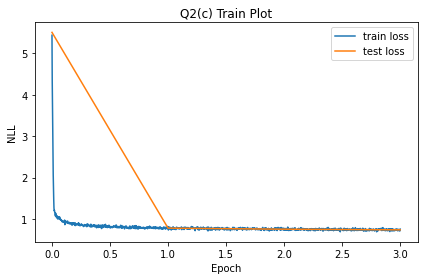

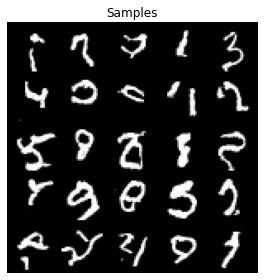

In [40]:
q2c_save_results(q2_c, train_data, test_data)

 ### <font color='red'> Inline Question 5 </font>

*   In question 2, you have implemented various PixelCNN models. You have seen the effective receptive fields of each of these models. It's time to visualize them. Please execute the nest cell to visualize receptive fields for PixelCNN and GatedPixelCNN (This cell should run with no issues if you have implemented the MaskedConv2d and GatedConv2d classes correctly, with the given arguments. If you have changed the input arguments etc. you might need to modify this cell.)
*   Please briefly explain your observations. What is the difference between the PixelCNN and GatedPixelCNN in terms of these receptive fields? What causes this difference and why is this important?



<font color='green'> My Answers </font>
  
  The difference between the PixelCNN and GatedPixelCNN in terms of their receptive fields is that PixelCNN suffers from the blind spot problem which causes it to have a smaller receptive field on certain locations of the image when compared to the receptive field of GatedPixelCNN. Therefore GatedPixelCNN has a larger receptive field. This blind spot problem stems from during generation of a pixel value model not being able to include all the previous pixels in the history. Therefore in the results below, for the PixelCNN we observe that some of the prior pixels of the right top of the target pixel are not included in the receptive field. On the other hand, GatedPixelCNN does not suffer form this issue and it is able to entail all of the prior history while generating target. This stems from the fact that GatedPixelCNN architecture uses both vertical and horizontal convolutions and combines their results in an autoregressive compliant way so that during the generation of the target all of the prior information is considered by the body. As a results GatedPixelCNN results at the bottom show that receptive field includes all of the prior pixel information.


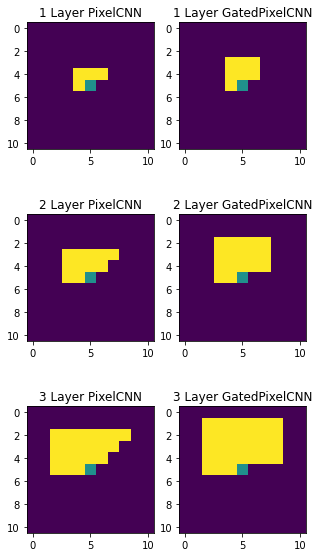

In [41]:
def visualize_receptive_field():
  layer1 = MaskedConv2d('A',1, 1, 3, 1, 1).cuda()
  layer2 = MaskedConv2d('B',1, 1, 3, 1, 1).cuda()
  gated_layer1 = GatedConv2d('A',1, 1, 3, 1).cuda()
  gated_layer2 = GatedConv2d('B',1, 1, 3, 1).cuda()
  x = torch.randn(1, 1, 11, 11).cuda()
  x.requires_grad = True
  x_g = torch.randn(1, 1, 11, 11).cuda()
  x_g.requires_grad = True
  nrows = 3
  fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(5,10))
  for j,row in enumerate(ax):
    out_g = torch.cat((x_g, x_g), dim=1)
    out_g = gated_layer1(out_g)
    out = layer1(x)
    for i in range(j):
      out = layer2(out)
      out_g = gated_layer2(out_g)
    out_g = out_g.chunk(2, dim=1)[1]
    col1, col2 = row
    plot_receptive_field(out, x, col1, ' PixelCNN', j+1)
    plot_receptive_field(out_g, x_g, col2, ' GatedPixelCNN', j+1)
    x.grad.zero_()
    x_g.grad.zero_()

visualize_receptive_field()

*This assignment is adapted from UC Berkeley [CS294-158-SP20](https://sites.google.com/view/berkeley-cs294-158-sp20/home)*